# Support Vector Machine

## **0. Introduction**

This notebook follows after the "Logistic_Regression.iypnb" notebook. Aim of this notebook is to conduct the Support Vector Machine algorithm. 

## **1. Masking**

As in the Logistic Regression notebook, we will first load the masks, load the data and then apply the mask. I will not explain each step, because this has already been described in the aformentioned notebook.

In [1]:
import os

os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")
os.listdir()

['sub-01_mask_LH_FFA.nii.gz',
 'sub-01_mask_LH_hV4.nii.gz',
 'sub-01_mask_LH_HVC.nii.gz',
 'sub-01_mask_LH_LOC.nii.gz',
 'sub-01_mask_LH_PPA.nii.gz',
 'sub-01_mask_LH_V1d.nii.gz',
 'sub-01_mask_LH_V1v.nii.gz',
 'sub-01_mask_LH_V2d.nii.gz',
 'sub-01_mask_LH_V2v.nii.gz',
 'sub-01_mask_LH_V3d.nii.gz',
 'sub-01_mask_LH_V3v.nii.gz',
 'sub-01_mask_RH_FFA.nii.gz',
 'sub-01_mask_RH_hV4.nii.gz',
 'sub-01_mask_RH_HVC.nii.gz',
 'sub-01_mask_RH_LOC.nii.gz',
 'sub-01_mask_RH_PPA.nii.gz',
 'sub-01_mask_RH_V1d.nii.gz',
 'sub-01_mask_RH_V1v.nii.gz',
 'sub-01_mask_RH_V2d.nii.gz',
 'sub-01_mask_RH_V2v.nii.gz',
 'sub-01_mask_RH_V3d.nii.gz',
 'sub-01_mask_RH_V3v.nii.gz']

In [2]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img = os.path.join(mask_img_path,'sub-01_mask_LH_HVC.nii.gz')

Just for the sake of trying something out, I choose a different mask this time. Instead of the v1 its going to be the **higher** visual cortex.

Also, for demonstration purposes, I will conduct the SVM with the z-maps **across** runs. A PCA on the z-maps across runs will follow at the end of this section to further illustrate the session specific variance issue.

In [3]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img)

In [4]:
X = []
y = []
Sessions = []
category = 1
for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            y.append(category)
            Sessions.append(session)
            category=category+1
            if category == 27:
                category = 1

In [5]:
import numpy as np
import pandas as pd

y = np.array(y)
Y_ses = np.array(Sessions)
df =  pd.DataFrame(np.concatenate(X))
X = df.to_numpy()




In [6]:
print('Our model takes {} features/voxels and {} samples as an input'.format(X[0,:].shape, X[:,0].shape))

Our model takes (2293,) features/voxels and (104,) samples as an input


After checking the shape of our input data, we observe differences. We have far more features and far less samples. In theory, this does not benefit our model, since this just provokes overfitting. 

Like in the logistic regression notebook, I also tried a bunch of different techniques. This notebook will run the SVM on the aforementioned data. Sklearns feature selection modules [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and the hyperparameter tuning method [Gridsearch](https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search) are demonstrated.

So lets jump straight in by splitting our data into training and testing variables with sklearns [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method.

## **1.0 Support Vector Machine**



Next step: Choosing our feature selection method.

We will use the **k**-best features from our 2293 features. The goal is to prevent overfitting by reducing features. 
The k-best methods works like this:

"Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores. Default is f_classif (see below “See Also”). The default function only works with classification tasks."

[SOURCE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)

So lets set k = 10 and continue running the SVM with our 10 best features!

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_kb= SelectKBest(f_classif, k=10).fit_transform(X, y)

In [8]:
print('Please note the newly obtained shape of the input matrix X: {}'.format(X_kb.shape))

Please note the newly obtained shape of the input matrix X: (104, 10)


In [9]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_kb, y, test_size=0.2,random_state=42)

We choose a 80/20 split, meaning that 80% of our data will be used for training the data and 20% for testing the data.

Random state is set to 42 for reproduction reasons

We will normalize the data as usual...

In [10]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)

<div class="alert alert-block alert-success">
Now its time to run the svm. Luckily enough, sklearn provides a method for the svm. We will define our model very naive and fit it on the data, check our classification report and confusion matrix as usual. Then we start sklearns gridsearch to tune the hyperparameters.

The following parameters can be tuned:
**gamma**, **C**. **The kernel** can also be adapted. We will start with random values of gamme = 1,  C = 0.1 and a linear kernel.</div>

In [11]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
clf = svm.SVC(gamma = 1,C = 0.1, kernel='linear') # Linear Kernel

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.29      0.50      0.36         4
           5       0.00      0.00      0.00         2
           6       0.50      0.33      0.40         3
           7       0.33      0.25      0.29         4
           8       0.00      0.00      0.00         3
           9       0.22      0.50      0.31         4
          10       0.50      0.75      0.60         4
          11       0.00      0.00      0.00         2
          12       0.25      0.75      0.38         4
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.30      0.75      0.43         4
          16       1.00      0.33      0.50         3
          17       0.22      0.50      0.31         4
          18       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [12]:
y_pred_test = clf.predict(scaler.transform(X_test))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       2.0
           6       0.00      0.00      0.00       1.0
           7       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       2.0
          12       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       2.0
          14       0.00      0.00      0.00       2.0
          15       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       1.0
          17       0.00      0.00      0.00       0.0
          18       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

We notice that the SVM performs not great on the training data, with accuracies around 30%. Not extremly horrible, but this can be adapted. The performance on the testing data, as usual, is around 0%... yeah.

We can plot the confusion matrices before continuing with the gridsearch.

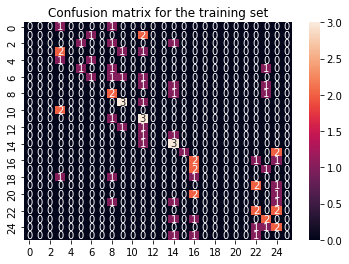

In [13]:
import seaborn as sns
cf_matrix_train = confusion_matrix(y_train, y_pred)
sns.heatmap(cf_matrix_train, annot = True).set(title='Confusion matrix for the training set');

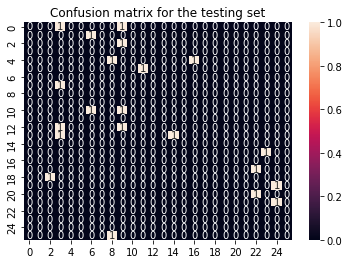

In [14]:
cf_matrix_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cf_matrix_test, annot = True).set(title='Confusion matrix for the testing set');

So lets continue with sklearns GridSearchCV.

This methods works like this:

We set up a **parameter_grid** with the parameters we want to tune. We also set a bunch of options, i.e different values for C, gamma and the kernel. Gridsearch will now fit the model with all those different combinations and provide us with an answer, which hyperparameters lead to the best results.

Without further ado, lets import the GridSearchCV method and run our model.

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf','sigmoid']} 

In [17]:
grid = GridSearchCV(svm.SVC(), param_grid,cv = 3,refit = True,verbose = 2)
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, 

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  UserWarning,


[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................

[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=100, gamma=0.1, kernel=linear; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ......................C=100, gamma=0.1, kernel=poly; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=2)

After fitting the model, we can now access the parameters that seem to work the best after the hyperparameter tuning. We can then predict our training and testing data once again and compare it with the "untuned" SVM from the beginning.

In [18]:
#print best parameter after tuning
print(grid.best_params_)
  # print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 0.1, 'gamma': 1, 'kernel': 'sigmoid'}
SVC(C=0.1, gamma=1, kernel='sigmoid')


In [19]:
grid_predictions = grid.predict(X_train)
  
# print classification report
print(classification_report(y_train, grid_predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.33      0.50      0.40         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.25      0.25      0.25         4
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         4
          10       0.15      0.75      0.25         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.11      0.25      0.15         4
          16       0.00      0.00      0.00         3
          17       0.06      0.25      0.10         4
          18       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [20]:
grid_predictions_test = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions_test))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       2.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       2.0
           6       0.00      0.00      0.00       1.0
           8       0.00      0.00      0.00       1.0
          11       0.00      0.00      0.00       2.0
          12       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       2.0
          14       0.00      0.00      0.00       2.0
          15       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       1.0
          18       0.00      0.00      0.00       1.0
          19       0.00      0.00      0.00       1.0
          20       0.00      0.00      0.00       1.0
          21       0.00      0.00      0.00       1.0
          22       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

<div class="alert alert-block alert-success">
Interestingly enough, the model peforms actually worse. This probably means the following. The naive settings from the first SVM were actually good enough and hyperparameter tuning can not improve the performance of our model.</div>

So this did not work. I'll continue anyway by introducing another straw I took inorder to defy those session specific correlations.

As mentioned in the Logistic Regression notebook, one idea was to randomly select the data from all sessions. The idea was to create a training and testing data that a) has a random amount from all sessions, so one session is not "over represented" and b) the test set actually contains all 26 categories and they are randomly choosen from all sessions available.

**Step 1**:

Get all unique labels from y. This variable will serve as a comparism to the y_test variable.

**Step 2**:

Set up the loop. The loop works like this: y is going to be randomly shuffled, so the data from all sessions are mixed up. Then empty training and testing variables are created.

The loop then iterates through the randomly sorted y variable. If the length of y test matches that of y unique, so 26 samples are stored in y test, the training data will append categories and indices.

If they are not equal, the test variables will append categories and indices. 

BUT: If one category appears twice in the test set(this is what we defintely not want, as explained above), we will remove this specific category from the test set and append it on the training set.

This way we make sure, that random variables are assigned to both training and test sets **and** the length of the test set matches 26 and contains all unique labels.

The indices are appended for the input matrix X. We will afterwards get the respective voxel patterns from X, according to the index. This needs to be done, so the voxel pattern of X actually matches the respective y label.

In [21]:
Y_unique = np.unique(y)
Y_unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [22]:
np.random.shuffle(y)
y_train_ = []
y_test_ = []
X_train_indices = []
X_test_indices = []



for index, category in enumerate(y):
    if len(y_test_) == len(Y_unique):
        y_train_.append(category)
        X_train_indices.append(index)
    else:
        y_test_.append(category)
        X_test_indices.append(index)
        if y_test_.count(category) > 1:
            y_test_.remove(category)
            y_train_.append(category)
            X_test_indices.remove(index)
            X_train_indices.append(index)
            continue
            
                

In [23]:
y_test_ = np.array(y_test_)
y_train_ = np.array(y_train_)
X_test_indices = np.array(X_test_indices)
X_train_indices = np.array(X_train_indices)

In [24]:
y_test_.shape

(26,)

In [26]:
X_test_indices.shape

(26,)

In [27]:
X_train_indices.shape

(78,)

In [28]:
y_train_.shape

(78,)

The shape matches the data. 26 test labels and 78 remaining labels for training. Now we will define X train and X test according to the indices and run the SVM again.

In [29]:
X_train_ = []
for index in X_train_indices:
    X_train_.append(X_kb[index])

In [30]:
X_train_ = np.array(X_train_)

In [31]:
X_train_[0]

array([ 6.25626526,  6.92034682,  3.99165056,  5.03150966,  7.93985189,
        6.10372678,  5.19518384,  0.49008551, -0.12572179,  3.79744318])

In [33]:
X_kb[X_train_indices[0]]

array([ 6.25626526,  6.92034682,  3.99165056,  5.03150966,  7.93985189,
        6.10372678,  5.19518384,  0.49008551, -0.12572179,  3.79744318])

We make sure that the method worked by comparing the first entry on our newly defined X train variable with the respective index, obtained in the loop, in our X matrix.

Since it matches we can happily continue with the testing data.

In [34]:
X_test_ = []
for index in X_test_indices:
    X_test_.append(X_kb[index])

In [35]:
X_test_ = np.array(X_test_)

Now we can set up the SVM again and see how the results compare.

In [36]:
clf = svm.SVC(gamma = 1,C = 0.1, kernel='linear') # Linear Kernel

clf.fit(X_train_, y_train_)

y_pred = clf.predict(X_train_)
print(classification_report(y_train_, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.11      0.33      0.17         3
           3       0.50      0.67      0.57         3
           4       1.00      0.67      0.80         3
           5       0.40      0.67      0.50         3
           6       0.33      0.33      0.33         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         3
           9       0.25      0.67      0.36         3
          10       0.00      0.00      0.00         3
          11       0.25      0.33      0.29         3
          12       0.50      0.33      0.40         3
          13       1.00      0.67      0.80         3
          14       0.00      0.00      0.00         3
          15       0.17      0.33      0.22         3
          16       0.00      0.00      0.00         3
          17       0.15      0.67      0.25         3
          18       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [38]:
y_pred_test = clf.predict(scaler.transform(X_test_))
print(classification_report(y_test_, y_pred_test))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.04      1.00      0.07         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00    

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

It was a good try, but unfortunately it did not influence the results at all.
Even after reducing the features to 10, using Gridsearch **and** applying a customized training and testing set, the results remain poorly. 

We can now fit a PCA once again in order to illustrate the session specific correlation on the **across runs** data.

## **2.0 PCA**...(again)

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

So lets create a PCA with n_components = 10 and fit it once again on the X data. Then we plot the explained variancce ratio per component.

In [40]:
pca = PCA(n_components=10) #n_components = 10
pca.fit(X)

PCA(n_components=10)

Text(0.5, 1.0, 'Explained variance ratio')

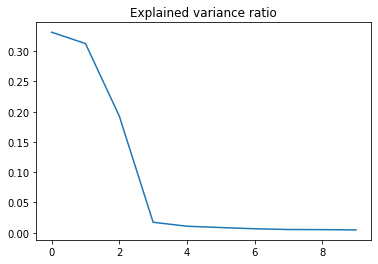

In [47]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance ratio')

So no variance at all is explained after this fourth component. This just further confirms the assumption of the high session specific variance.

We can pca.transform X and then plot the transformed X matrix. This solely containts X with the 10 components from the fitted PCA. If we plot this, we can observe the pattern in our data.

In [42]:
X_transform = pca.transform(X)

In [43]:
X_transform.shape

(104, 10)

Text(0, 0.5, 'PC 2')

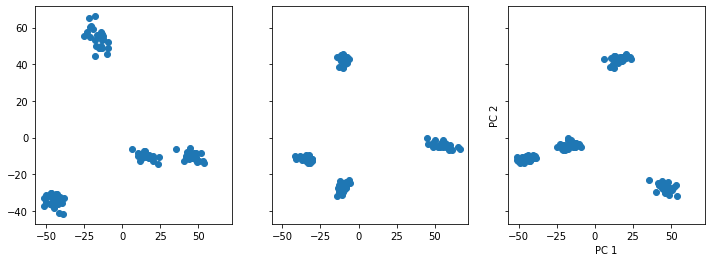

In [49]:
fig, ax =plt.subplots(figsize=(12, 4), ncols=3, sharey=True, sharex=True)
ax[0].scatter(X_transform[:, 0], X_transform[:, 1])
ax[1].scatter(X_transform[:, 1], X_transform[:, 2])
ax[2].scatter(X_transform[:, 0], X_transform[:, 2])
plt.xlabel('PC 1')
plt.ylabel('PC 2')

The PCA plots are giving us the following information:
    
Mainly 4 components explain almost all of the variance in the data. This is evident by the cluster plot, when plotting those components. 4 clusters are observed, representing the 4 sessions.

Text(0.5, 1.0, 'Correlation plot of the X data')

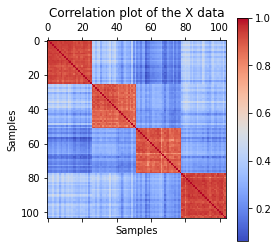

In [50]:
import matplotlib.pyplot as plt
corr =np.corrcoef(X)
plt.matshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.title('Correlation plot of the X data')

The PCA results are further validated by a correlation matrix, which very obviously validates the high session specific correlation pattern.

We can create a random noise variable and plot both the Input data and the random noise plot. This illustrates, that after those 4 components in our data, nothing else but noise exists.

In [45]:
rand_X = np.random.normal(size=X.shape)
pca_rand = PCA()
pca_rand.fit(rand_X)

PCA()

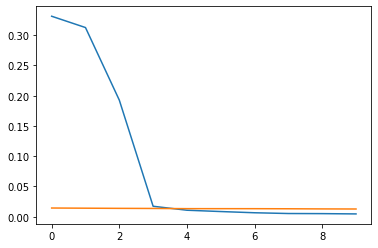

In [46]:
plt.plot(pca.explained_variance_ratio_[:10])
plt.plot(pca_rand.explained_variance_ratio_[:10])

<div class="alert alert-block alert-danger">
Unfortunately the SVM did not help us with solving our hypothesis. We will now continue with setting up a Deep Neural Network. Please proceed.</div>